In [5]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import warnings
warnings.filterwarnings('ignore')

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Set dataset path
BASE_PATH = "/content/drive/MyDrive/EJUST-GYM-3/processed/"
MODEL_SAVE_PATH = '/content/drive/MyDrive/new_models'
os.makedirs(MODEL_SAVE_PATH, exist_ok=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
import numpy as np

EXERCISE_CLASSES = ['situps', 'jumping_jacks', 'high_knee', 'steam_engine']
NUM_CLASSES = len(EXERCISE_CLASSES)
LABEL_MAP = {exercise: idx for idx, exercise in enumerate(EXERCISE_CLASSES)}
MAX_FRAMES = 30
POSE_DIM = 99  # 33 landmarks * 3 coordinates
NUM_LANDMARKS = 33
NUM_COORDINATES = 3

def get_label_index(exercise_name):
    return LABEL_MAP.get(exercise_name, -1)

def validate_pose_data(pose):
    if pose.shape != (MAX_FRAMES, POSE_DIM) or np.any(np.isnan(pose)) or np.all(pose == 0):
        return False
    return True

def normalize_pose(pose):
    # Reshape pose to (30, 33, 3) for 30 frames, 33 landmarks, 3 coordinates
    pose_reshaped = pose.reshape(MAX_FRAMES, NUM_LANDMARKS, NUM_COORDINATES)

    # Extract hip landmarks (indices 23 and 24)
    hip_left = pose_reshaped[:, 23, :]
    hip_right = pose_reshaped[:, 24, :]
    hip_center = (hip_left + hip_right) / 2  # Shape: (30, 3)

    # Center the pose by subtracting hip_center, broadcasting (30, 3) to (30, 33, 3)
    pose_centered = pose_reshaped - hip_center[:, np.newaxis, :]

    # Extract shoulder landmarks (indices 11 and 12)
    shoulder_left = pose_reshaped[:, 11, :]
    shoulder_right = pose_reshaped[:, 12, :]
    shoulder_center = (shoulder_left + shoulder_right) / 2  # Shape: (30, 3)

    # Compute torso length as the norm between shoulder_center and hip_center
    torso_length = np.linalg.norm(shoulder_center - hip_center, axis=1)  # Shape: (30,)
    torso_length = np.maximum(torso_length, 1e-5)  # Avoid division by zero

    # Normalize by scaling with torso length, broadcasting (30, 1, 1) to (30, 33, 3)
    pose_normalized = pose_centered / torso_length[:, np.newaxis, np.newaxis]

    # Reshape back to (30, 99)
    return pose_normalized.reshape(MAX_FRAMES, POSE_DIM)

def augment_pose(pose):
    noise = np.random.normal(0, 0.01, pose.shape)
    return pose + noise

In [7]:
import pandas as pd
import os

def load_all_pose_data(base_path, exercises, max_frames=MAX_FRAMES):
    data = []
    labels = []
    for person in sorted(os.listdir(base_path)):
        person_path = os.path.join(base_path, person)
        if not os.path.isdir(person_path):
            continue
        for exercise in exercises:
            pose_folder = os.path.join(person_path, exercise, "poses", "csv")
            if not os.path.exists(pose_folder):
                continue
            csv_files = [f for f in os.listdir(pose_folder) if f.endswith(".csv")]
            for fname in sorted(csv_files):
                csv_path = os.path.join(pose_folder, fname)
                try:
                    df = pd.read_csv(csv_path)
                    # Check if the CSV has exactly 99 columns
                    if df.shape[1] != POSE_DIM:
                        print(f"Skipping {csv_path}: expected {POSE_DIM} columns, got {df.shape[1]}")
                        continue
                    pose = df.values.astype(np.float32)
                    # Pad or truncate to MAX_FRAMES
                    if pose.shape[0] < max_frames:
                        pad = np.zeros((max_frames - pose.shape[0], POSE_DIM), dtype=np.float32)
                        pose = np.vstack((pose, pad))
                    else:
                        pose = pose[:max_frames]
                    # Validate the pose data
                    if validate_pose_data(pose):
                        pose_normalized = normalize_pose(pose)
                        data.append(pose_normalized)
                        labels.append(get_label_index(exercise))
                    else:
                        print(f"Skipping {csv_path}: invalid pose data")
                except Exception as e:
                    print(f"Failed to load {csv_path}: {e}")
    return np.array(data), np.array(labels)

# Assuming BASE_PATH is defined, e.g., BASE_PATH = "/content/drive/MyDrive/EJUST-GYM-3/processed"
X, y = load_all_pose_data(BASE_PATH, EXERCISE_CLASSES)
print(f"Loaded {len(X)} sequences")

# Apply data augmentation
X_augmented = np.array([augment_pose(x) for x in X])

# Reshape X for the model
X_augmented = X_augmented.reshape(-1, MAX_FRAMES, POSE_DIM)
print(f"Data shape: {X_augmented.shape}, Labels shape: {y.shape}")

Failed to load /content/drive/MyDrive/EJUST-GYM-3/processed/12-Youssef Elamir Nabil/steam_engine/poses/csv/c_9.csv: No columns to parse from file
Failed to load /content/drive/MyDrive/EJUST-GYM-3/processed/121-Mohamed Hussien Kamal/high_knee/poses/csv/c_9.csv: No columns to parse from file
Skipping /content/drive/MyDrive/EJUST-GYM-3/processed/78-Omar Said Fares/jumping_jacks/poses/csv/c_1.csv: invalid pose data
Loaded 5545 sequences
Data shape: (5545, 30, 99), Labels shape: (5545,)


In [8]:
X_train, X_temp, y_train, y_temp = train_test_split(X_augmented, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)
print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

Train: (3881, 30, 99), Val: (832, 30, 99), Test: (832, 30, 99)


In [9]:
model = keras.Sequential([
    layers.LSTM(256, input_shape=(MAX_FRAMES, POSE_DIM), return_sequences=False),
    layers.Dropout(0.4),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(64, activation='relu'),
    layers.Dense(NUM_CLASSES, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 256)            │       364,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 405,956 (1.55 MB)

 Trainable params: 405,956 (1.55 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
122/122 ━━━━━━━━━━━━━━━━━━━━ 25s 175ms/step - accuracy: 0.8299 - loss: 0.4329 - val_accuracy: 0.9820 - val_loss: 0.1040 - learning_rate: 0.0010
Epoch 2/100
122/122 ━━━━━━━━━━━━━━━━━━━━ 34s 122ms/step - accuracy: 0.9941 - loss: 0.0219 - val_accuracy: 0.9964 - val_loss: 0.0070 - learning_rate: 0.0010
Epoch 3/100
122/122 ━━━━━━━━━━━━━━━━━━━━ 16s 128ms/step - accuracy: 0.9919 - loss: 0.0329 - val_accuracy: 0.9988 - val_loss: 0.0045 - learning_rate: 0.0010
Epoch 4/100
122/122 ━━━━━━━━━━━━━━━━━━━━ 19s 160ms/step - accuracy: 0.9839 - loss: 0.0440 - val_accuracy: 0.9988 - val_loss: 0.0057 - learning_rate: 0.0010
Epoch 5/100
122/122 ━━━━━━━━━━━━━━━━━━━━ 17s 127ms/step - accuracy: 0.9996 - loss: 0.0025 - val_accuracy: 0.9988 - val_loss: 0.0015 - learning_rate: 0.0010
Epoch 6/100
122/122 ━━━━━━━━━━━━━━━━━━━━ 20s 121ms/step - accuracy: 1.0000 - loss: 7.0279e-04 - val_accuracy: 1.0000 - val_loss: 5.6796e-04 - learning_rate: 0.0010
Epoch 7/100
122/122 ━━━━━━━━━━━━━━━━━━━━ 21s 121ms/step 

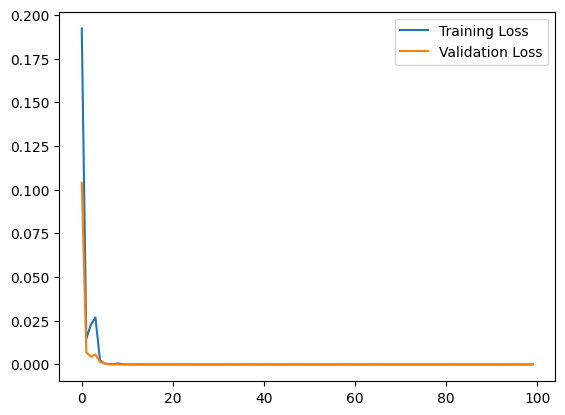

In [10]:
callbacks = [
    EarlyStopping(patience=15, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.5, patience=5),
    ModelCheckpoint(os.path.join(MODEL_SAVE_PATH, 'best_model.keras'), save_best_only=True)
]

history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                    epochs=100, batch_size=32, callbacks=callbacks)

# Plot training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

Loaded trained model from /content/drive/MyDrive/new_models/best_model.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.9996 - loss: 0.0011    
Test Loss: 0.003268727334216237, Test Accuracy: 0.9987980723381042
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step

Classification Report:
               precision    recall  f1-score   support

       situps       1.00      1.00      1.00       182
jumping_jacks       1.00      1.00      1.00       230
    high_knee       1.00      1.00      1.00       240
 steam_engine       1.00      0.99      1.00       180

     accuracy                           1.00       832
    macro avg       1.00      1.00      1.00       832
 weighted avg       1.00      1.00      1.00       832



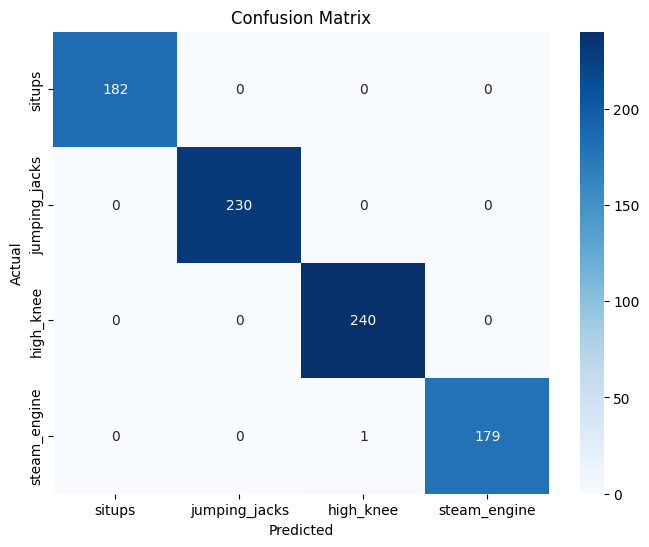

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
import os

# Ensure the trained model is loaded
MODEL_SAVE_PATH = '/content/drive/MyDrive/new_models'
model_path = os.path.join(MODEL_SAVE_PATH, 'best_model.keras')

# Check if the trained model exists and load it
if os.path.exists(model_path):
    model = tf.keras.models.load_model(model_path)
    print(f"Loaded trained model from {model_path}")
else:
    # Fallback: Define and compile the model as in cell 5
    print("Trained model not found, defining and compiling model from cell 5")
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(256, input_shape=(30, 99), return_sequences=False),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(4, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Evaluate on test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

# Generate predictions for detailed metrics
y_pred = np.argmax(model.predict(X_test), axis=1)
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=EXERCISE_CLASSES))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues',
            xticklabels=EXERCISE_CLASSES, yticklabels=EXERCISE_CLASSES)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [22]:
import tensorflow as tf
import os

# Save the trained model in .keras format
model.save(os.path.join(MODEL_SAVE_PATH, 'trained_model.keras'))
print(f"Saved trained model to {os.path.join(MODEL_SAVE_PATH, 'trained_model.keras')}")

# Define inference model without dropout, matching trained model architecture
inference_model = tf.keras.Sequential([
    tf.keras.layers.LSTM(256, input_shape=(30, 99), return_sequences=False, dtype='float32'),
    tf.keras.layers.Dense(128, activation='relu', dtype='float32'),
    tf.keras.layers.Dense(64, activation='relu', dtype='float32'),
    tf.keras.layers.Dense(4, activation='softmax', dtype='float32')
])

# Load trained model
trained_model = tf.keras.models.load_model(os.path.join(MODEL_SAVE_PATH, 'trained_model.keras'))
print("Loaded trained model")

# Explicitly copy weights, skipping dropout layers
trained_layers = [layer for layer in trained_model.layers if 'dropout' not in layer.name]
inference_layers = inference_model.layers

if len(trained_layers) != len(inference_layers):
    raise ValueError(f"Layer count mismatch: trained model has {len(trained_layers)} non-dropout layers, inference model has {len(inference_layers)} layers")

for trained_layer, inference_layer in zip(trained_layers, inference_layers):
    print(f"Copying weights from {trained_layer.name} to {inference_layer.name}")
    inference_layer.set_weights(trained_layer.get_weights())

# Convert to TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(inference_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,
    tf.lite.OpsSet.SELECT_TF_OPS
]
tflite_model = converter.convert()

# Save the TFLite model
tflite_path = os.path.join(MODEL_SAVE_PATH, 'exercise_model_optimized.tflite')
with open(tflite_path, 'wb') as f:
    f.write(tflite_model)
print(f"TFLite model saved to {tflite_path}")

# Display model summary for transparency
inference_model.summary()

Saved trained model to /content/drive/MyDrive/new_models/trained_model.keras
Loaded trained model
Copying weights from lstm to lstm_3
Copying weights from dense to dense_7
Copying weights from dense_1 to dense_8
Copying weights from dense_2 to dense_9
Saved artifact at '/tmp/tmpe1w2qvta'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 30, 99), dtype=tf.float32, name='keras_tensor_57')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  140518040816144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140518040817872: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140518040818448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140518040817488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140518040818832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140518040817680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140518040819600: TensorSpec(shape=(), dtype=

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 256)            │       364,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 405,956 (1.55 MB)

 Trainable params: 405,956 (1.55 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:
import tensorflow as tf
import numpy as np

# Simulate real-time input by using a test sample
def simulate_realtime_input(sample):
    # Apply the same normalization as during training
    sample_normalized = normalize_pose(sample)
    return sample_normalized.astype(np.float32)

# Load TFLite model and allocate tensors
interpreter = tf.lite.Interpreter(model_path=os.path.join(MODEL_SAVE_PATH, 'exercise_model_optimized.tflite'))
interpreter.allocate_tensors()

# Get input and output tensors
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Test with multiple samples from test set
for sample_idx in range(10):  # Test first 5 samples
    input_data = simulate_realtime_input(X_test[sample_idx])
    interpreter.set_tensor(input_details[0]['index'], np.expand_dims(input_data, axis=0))
    interpreter.invoke()
    output_data = interpreter.get_tensor(output_details[0]['index'])
    predicted_class = np.argmax(output_data[0])
    print(f"Sample {sample_idx}: Predicted: {EXERCISE_CLASSES[predicted_class]}, Actual: {EXERCISE_CLASSES[y_test[sample_idx]]}")

Sample 0: Predicted: high_knee, Actual: high_knee
Sample 1: Predicted: steam_engine, Actual: steam_engine
Sample 2: Predicted: jumping_jacks, Actual: jumping_jacks
Sample 3: Predicted: jumping_jacks, Actual: jumping_jacks
Sample 4: Predicted: steam_engine, Actual: steam_engine
Sample 5: Predicted: high_knee, Actual: high_knee
Sample 6: Predicted: jumping_jacks, Actual: jumping_jacks
Sample 7: Predicted: jumping_jacks, Actual: jumping_jacks
Sample 8: Predicted: jumping_jacks, Actual: jumping_jacks
Sample 9: Predicted: steam_engine, Actual: steam_engine


In [26]:
from sklearn.metrics import classification_report, confusion_matrix

# Get predictions from the model
y_pred = model.predict(X_test)

# Convert predictions to class indices
y_pred_classes = y_pred.argmax(axis=1)

# Use y_test directly since it’s already integer labels
print(classification_report(y_test, y_pred_classes, target_names=['situps', 'jumping_jacks', 'high_knees', 'steam_engines']))
print(confusion_matrix(y_test, y_pred_classes))

# Optional: Evaluate test loss and accuracy
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step
               precision    recall  f1-score   support

       situps       1.00      1.00      1.00       182
jumping_jacks       1.00      1.00      1.00       230
   high_knees       1.00      1.00      1.00       240
steam_engines       1.00      0.99      1.00       180

     accuracy                           1.00       832
    macro avg       1.00      1.00      1.00       832
 weighted avg       1.00      1.00      1.00       832

[[182   0   0   0]
 [  0 230   0   0]
 [  0   0 240   0]
 [  0   0   1 179]]
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - accuracy: 0.9996 - loss: 0.0011    
Test Loss: 0.003268727334216237, Test Accuracy: 0.9987980723381042


In [28]:
import os
tflite_size = os.path.getsize('exercise_model_optimized.tflite') / (1024 * 1024)  # Size in MB
print(f"TFLite model size: {tflite_size:.2f} MB")

TFLite model size: 0.06 MB
